### Import dataset

In [3]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
# dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]
dog_names = [item[20:-1] for item in sorted(glob('dogImages/train/*/'))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [4]:
#Import human files
import random
random.seed(8675309)

# load filenames in shuffled human dataset
# human_files = np.array(glob("../../../data/lfw/*/*"))
human_files = np.array(glob("data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


In [5]:
from tensorflow.keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|█████████████████████████████████████████████████████████████████████████████| 6680/6680 [00:46<00:00, 143.36it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Alireza\.conda\envs\keras\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-0423aab06fc1>", line 5, in <module>
    train_tensors = paths_to_tensor(train_files).astype('float32')/255
  File "<ipython-input-5-4a45c91277ac>", line 14, in paths_to_tensor
    return np.vstack(list_of_tensors)
  File "<__array_function__ internals>", line 6, in vstack
  File "C:\Users\Alireza\.conda\envs\keras\lib\site-packages\numpy\core\shape_base.py", line 283, in vstack
    return _nx.concatenate(arrs, 0)
  File "<__array_function__ internals>", line 6, in concatenate
MemoryError: Unable to allocate 3.75 GiB for an array with shape (6680, 224, 224, 3) and data type float32

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Alireza\.conda\envs\keras\lib\site-packages\IPython\core\

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint 

ERROR! Session/line number was not unique in database. History logging moved to new session 44


In [7]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen =ImageDataGenerator(
            rescale = 1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'dogImages/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use 

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'dogImages/valid',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [8]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(133, activation='softmax'))


### TODO: Define your architecture.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       3

In [9]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 50

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.augmentation.50epochs.hdf5', 
                               verbose=1, save_best_only=True)

history =  model.fit(train_generator, 
                  validation_data=validation_generator,
                  epochs=epochs,  batch_size=20, callbacks=[checkpointer], verbose=1) 
# steps_per_epoch=2000 // batch_size,
# validation_steps=800 // batch_size,

Epoch 1/50
418/418 [==============================] - 128s 306ms/step - loss: 4.5883 - accuracy: 0.0290 - val_loss: 4.4912 - val_accuracy: 0.0263

Epoch 00001: val_loss improved from inf to 4.49116, saving model to saved_models\weights.best.augmentation.50epochs.hdf5
Epoch 2/50
418/418 [==============================] - 128s 306ms/step - loss: 4.5633 - accuracy: 0.0278 - val_loss: 4.5427 - val_accuracy: 0.0287

Epoch 00002: val_loss did not improve from 4.49116
Epoch 3/50
418/418 [==============================] - 127s 305ms/step - loss: 4.5263 - accuracy: 0.0337 - val_loss: 4.4127 - val_accuracy: 0.0275

Epoch 00003: val_loss improved from 4.49116 to 4.41274, saving model to saved_models\weights.best.augmentation.50epochs.hdf5
Epoch 4/50
418/418 [==============================] - 126s 302ms/step - loss: 4.4726 - accuracy: 0.0413 - val_loss: 4.3001 - val_accuracy: 0.0443

Epoch 00004: val_loss improved from 4.41274 to 4.30015, saving model to saved_models\weights.best.augmentation.50ep

418/418 [==============================] - 121s 290ms/step - loss: 4.0243 - accuracy: 0.0774 - val_loss: 3.8784 - val_accuracy: 0.0886

Epoch 00037: val_loss improved from 3.88621 to 3.87844, saving model to saved_models\weights.best.augmentation.50epochs.hdf5
Epoch 38/50
418/418 [==============================] - 122s 291ms/step - loss: 4.0238 - accuracy: 0.0796 - val_loss: 3.9038 - val_accuracy: 0.0970

Epoch 00038: val_loss did not improve from 3.87844
Epoch 39/50
418/418 [==============================] - 121s 291ms/step - loss: 4.0361 - accuracy: 0.0804 - val_loss: 3.8316 - val_accuracy: 0.0886

Epoch 00039: val_loss improved from 3.87844 to 3.83160, saving model to saved_models\weights.best.augmentation.50epochs.hdf5
Epoch 40/50
418/418 [==============================] - 123s 295ms/step - loss: 4.0246 - accuracy: 0.0805 - val_loss: 4.0976 - val_accuracy: 0.0659

Epoch 00040: val_loss did not improve from 3.83160
Epoch 41/50
418/418 [==============================] - 124s 297ms/st

In [21]:
# Load the model
model.load_weights('saved_models/weights.best.augmentation.50epochs.hdf5')

In [22]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy after 5 epochs: %.4f%%' % test_accuracy)

Test accuracy after 5 epochs: 10.1675%


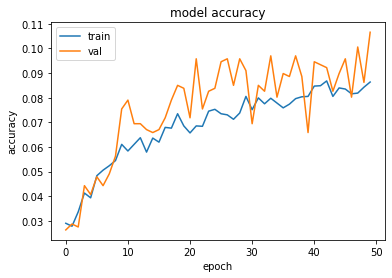

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

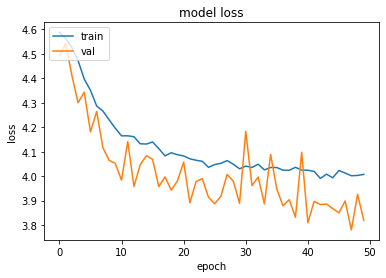

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

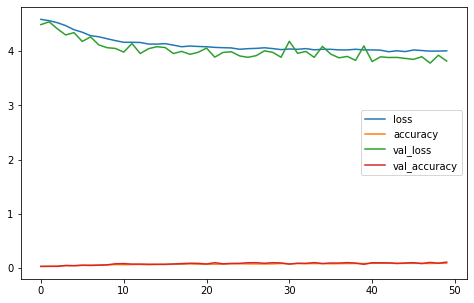

In [24]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [10]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('dogImages/train/002.Afghan_hound/Afghan_hound_00081.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [8]:
img = load_img('dogImages/train/002.Afghan_hound/Afghan_hound_00081.jpg')  # this is a PIL image